# Comparative Analysis (REVISED): Pangenome, Pathways, and Niche Breadth

This notebook analyzes relationships between:
1. **Pangenome openness** (accessory/core ratio)
2. **Metabolic pathway completeness** (# of complete GapMind pathways)
3. **Ecological niche breadth** (AlphaEarth embedding diversity)

## Revised Hypotheses

**H1: Pangenome → Pathway Completeness**  
Open pangenomes (high accessory/core) have MORE variable pathway completeness across genomes (intra-species diversity).

**H2: Niche Breadth → Pathway Completeness**  
Species with broader ecological niches (high AlphaEarth embedding diversity) have higher median pathway completeness.

**H3: Pangenome → Niche Breadth**  
Open pangenomes correlate with broader ecological niches (embedding diversity).

**Prerequisites**: Run `01_data_extraction_REVISED.ipynb` first.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Create figures directory
fig_dir = Path('../figures')
fig_dir.mkdir(exist_ok=True)

## 1. Load Integrated Dataset

In [2]:
# Load integrated dataset
data_dir = Path('../data')
df = pd.read_csv(data_dir / 'integrated_dataset.csv')

print(f"Total species: {len(df)}")
print(f"\nData availability:")
print(f"  Pangenome data: {len(df)} (100%)")
print(f"  Pathway data: {df['mean_complete_pathways'].notna().sum()} ({df['mean_complete_pathways'].notna().sum() / len(df) * 100:.1f}%)")
print(f"  Niche breadth data: {df['niche_breadth_score'].notna().sum()} ({df['niche_breadth_score'].notna().sum() / len(df) * 100:.1f}%)")

# Filter for complete cases
df_complete = df[df[['mean_complete_pathways', 'niche_breadth_score']].notna().all(axis=1)].copy()
print(f"\nComplete cases (all three data types): {len(df_complete)}")

# Show data range
print("\nData ranges:")
print(f"  Accessory/Core ratio: {df_complete['accessory_core_ratio'].min():.2f} - {df_complete['accessory_core_ratio'].max():.2f}")
print(f"  Mean complete pathways: {df_complete['mean_complete_pathways'].min():.1f} - {df_complete['mean_complete_pathways'].max():.1f}")
print(f"  Niche breadth score: {df_complete['niche_breadth_score'].min():.3f} - {df_complete['niche_breadth_score'].max():.3f}")

df_complete.head(10)

Total species: 27690

Data availability:
  Pangenome data: 27690 (100%)
  Pathway data: 27690 (100.0%)
  Niche breadth data: 1872 (6.8%)

Complete cases (all three data types): 1872

Data ranges:
  Accessory/Core ratio: 0.01 - 78.22
  Mean complete pathways: 0.0 - 79.0
  Niche breadth score: 0.000 - 1.384


,gtdb_species_clade_id,GTDB_species,GTDB_taxonomy,no_genomes,no_core,no_aux_genome,no_singleton_gene_clusters,no_gene_clusters,mean_intra_species_ANI,ANI_circumscription_radius,...,mean_lon,lat_range,lon_range,max_geodesic_dist_km,mean_geodesic_dist_km,max_embedding_dist,mean_embedding_dist,std_embedding_dist,embedding_variance,niche_breadth_score
3,s__Streptococcus_pneumoniae--RS_GCF_001457635.1,s__Streptococcus_pneumoniae,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...,8434,1475,115370,67191.0,116845,98.62,95.0000,...,18.353585,94.674421,235.800000,18784.952385,7397.429695,1.591833,1.081545,0.339592,0.010021,1.092382
9,s__Enterobacter_hormaechei_A--RS_GCF_001729745.1,s__Enterobacter_hormaechei_A,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,2453,3574,153463,95270.0,157037,96.68,95.0000,...,31.544869,91.906600,275.432100,19803.240413,7915.518001,1.602950,1.119058,0.317279,0.010557,1.130872
11,s__Enterococcus_faecalis--RS_GCF_000392875.1,s__Enterococcus_faecalis,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...,2250,2171,66620,35089.0,68791,98.68,95.0000,...,-23.847257,103.019538,290.264400,19711.855127,7575.760197,1.579628,1.101880,0.342207,0.010373,1.113310
13,s__Neisseria_meningitidis--RS_GCF_900638555.1,s__Neisseria_meningitidis,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,2121,1427,34542,17384.0,35969,97.79,95.0389,...,-3.953204,89.310000,235.505000,19855.536053,8804.937266,1.603338,1.208327,0.296252,0.012064,1.222904
18,s__Burkholderia_mallei--RS_GCF_000011705.1,s__Burkholderia_mallei,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,1741,5149,63820,33297.0,68969,99.31,95.0000,...,100.588829,81.407460,262.334060,18257.156383,4046.266983,1.520067,1.100229,0.422272,0.010815,1.112128
21,s__Streptococcus_agalactiae--RS_GCF_000186445.1,s__Streptococcus_agalactiae,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...,1487,1565,29031,14373.0,30596,98.62,95.0000,...,35.817834,97.542005,254.826500,19533.208652,5262.259427,1.520672,1.125819,0.429465,0.011297,1.138537
23,s__Pseudomonas_E_viridiflava--RS_GCF_001642795.1,s__Pseudomonas_E_viridiflava,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,1167,4524,58638,37856.0,63162,97.35,95.0000,...,-20.484248,28.452676,222.358611,12690.759138,6134.446001,1.516270,1.262778,0.150640,0.011056,1.276739
24,s__Campylobacter_D_coli--RS_GCF_000254135.1,s__Campylobacter_D_coli,d__Bacteria;p__Campylobacterota;c__Campylobact...,1130,1420,26559,13253.0,27979,98.67,95.0000,...,-7.065223,97.100000,266.881408,18966.378169,7450.190208,1.536514,1.130053,0.364570,0.010952,1.142429
25,s__Bordetella_pertussis--RS_GCF_000306945.1,s__Bordetella_pertussis,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,1019,3550,26476,13708.0,30026,99.45,95.0000,...,115.948578,97.389300,275.999900,19208.246554,7668.232258,1.508595,0.929948,0.347315,0.007559,0.936977
28,s__Francisella_tularensis--RS_GCF_000008985.1,s__Francisella_tularensis,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,852,1834,11273,7223.0,13107,99.29,95.0000,...,0.842294,40.155494,264.340000,13371.620476,4835.774810,1.533341,1.198380,0.316964,0.011931,1.212678


## 2. Hypothesis 1: Pangenome Openness vs. Pathway Completeness

Do open pangenomes have more complete metabolic pathways?

In [3]:
# Correlation analysis
print("H1: Pangenome Openness vs. Pathway Completeness")
print("=" * 70)

# Test multiple pangenome metrics
correlations = {
    'Accessory/Core Ratio vs Mean Complete': stats.pearsonr(
        df_complete['accessory_core_ratio'], 
        df_complete['mean_complete_pathways']
    ),
    'Core Fraction vs Mean Complete': stats.pearsonr(
        df_complete['core_fraction'], 
        df_complete['mean_complete_pathways']
    ),
    'Singleton Ratio vs Mean Complete': stats.pearsonr(
        df_complete['singleton_ratio'], 
        df_complete['mean_complete_pathways']
    ),
    'Accessory/Core Ratio vs Pathway Variability': stats.pearsonr(
        df_complete['accessory_core_ratio'], 
        df_complete['std_complete_pathways']
    ),
}

for metric, (r, p) in correlations.items():
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
    print(f"{metric:50s}: r = {r:7.3f}, p = {p:.2e} {sig}")

print("\nInterpretation:")
print("  - Positive r: Open pangenomes → more complete pathways")
print("  - Negative r: Open pangenomes → fewer complete pathways (genome streamlining?)")

H1: Pangenome Openness vs. Pathway Completeness
Accessory/Core Ratio vs Mean Complete             : r =   0.107, p = 3.62e-06 ***
Core Fraction vs Mean Complete                    : r =  -0.133, p = 6.71e-09 ***
Singleton Ratio vs Mean Complete                  : r =  -0.018, p = 4.39e-01 ns
Accessory/Core Ratio vs Pathway Variability       : r =   0.066, p = 4.17e-03 **

Interpretation:
  - Positive r: Open pangenomes → more complete pathways
  - Negative r: Open pangenomes → fewer complete pathways (genome streamlining?)


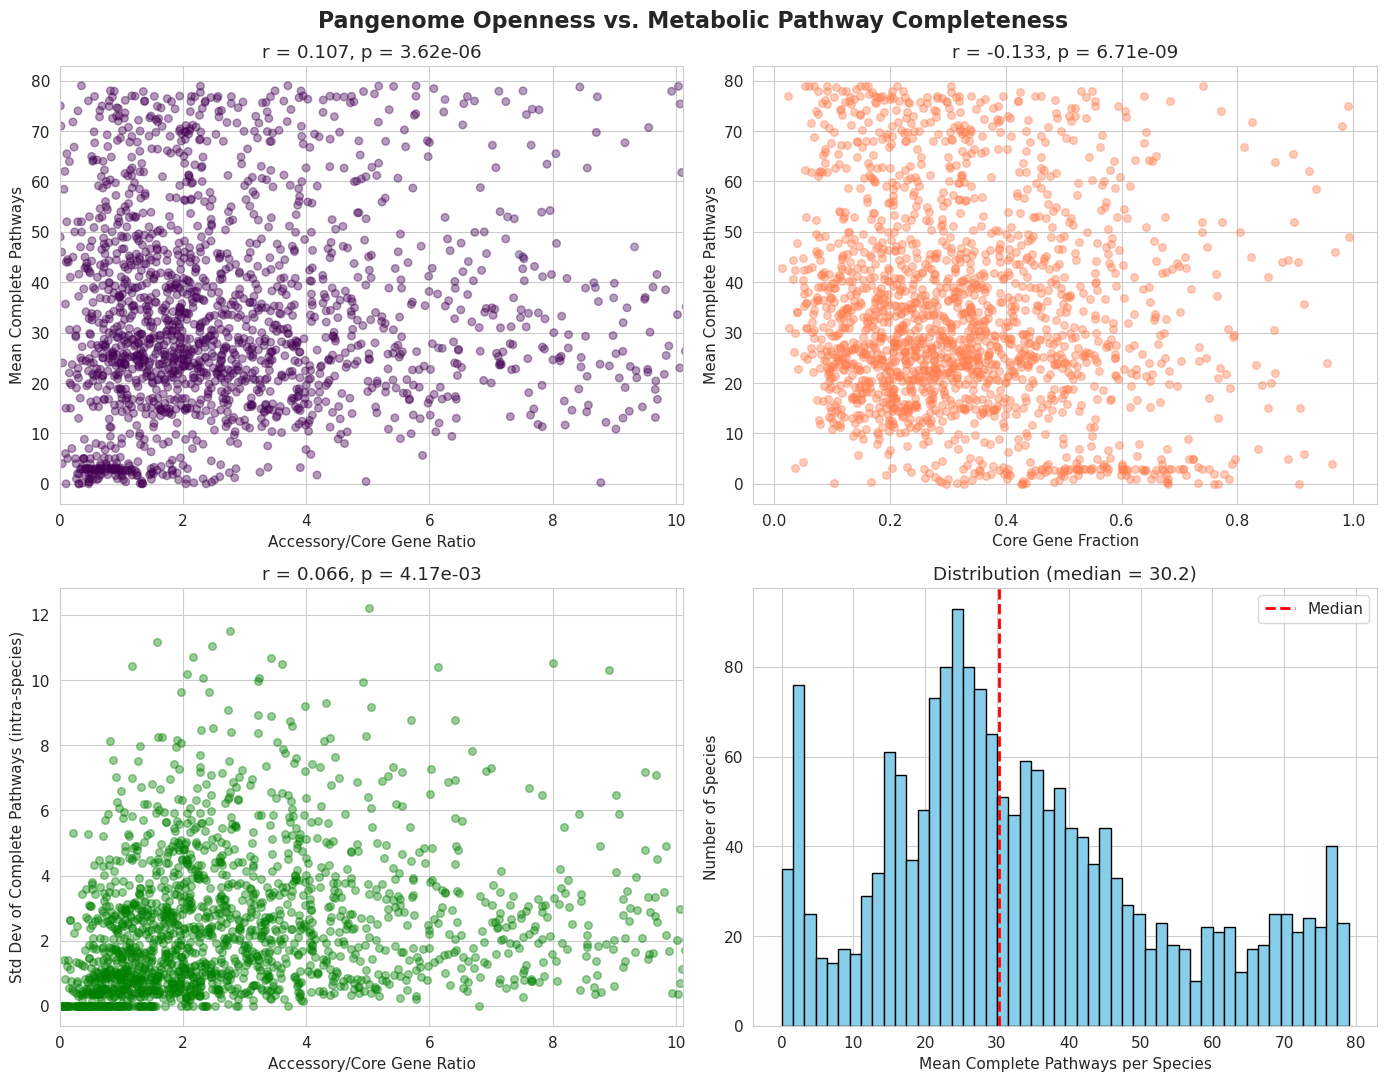

In [4]:
# Visualization: Pangenome vs Pathways
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle('Pangenome Openness vs. Metabolic Pathway Completeness', fontsize=16, fontweight='bold')

# Plot 1: Accessory/Core ratio vs Mean complete pathways
ax = axes[0, 0]
ax.scatter(df_complete['accessory_core_ratio'], df_complete['mean_complete_pathways'],
           alpha=0.4, s=30, c=df_complete['no_genomes'], cmap='viridis')
ax.set_xlabel('Accessory/Core Gene Ratio')
ax.set_ylabel('Mean Complete Pathways')
r, p = correlations['Accessory/Core Ratio vs Mean Complete']
ax.set_title(f"r = {r:.3f}, p = {p:.2e}")
ax.set_xlim(0, df_complete['accessory_core_ratio'].quantile(0.95))

# Plot 2: Core fraction vs Mean complete pathways
ax = axes[0, 1]
ax.scatter(df_complete['core_fraction'], df_complete['mean_complete_pathways'],
           alpha=0.4, s=30, color='coral')
ax.set_xlabel('Core Gene Fraction')
ax.set_ylabel('Mean Complete Pathways')
r, p = correlations['Core Fraction vs Mean Complete']
ax.set_title(f"r = {r:.3f}, p = {p:.2e}")

# Plot 3: Accessory/Core vs Pathway variability (STD)
ax = axes[1, 0]
ax.scatter(df_complete['accessory_core_ratio'], df_complete['std_complete_pathways'],
           alpha=0.4, s=30, color='green')
ax.set_xlabel('Accessory/Core Gene Ratio')
ax.set_ylabel('Std Dev of Complete Pathways (intra-species)')
r, p = correlations['Accessory/Core Ratio vs Pathway Variability']
ax.set_title(f"r = {r:.3f}, p = {p:.2e}")
ax.set_xlim(0, df_complete['accessory_core_ratio'].quantile(0.95))

# Plot 4: Distribution of pathway completeness
ax = axes[1, 1]
ax.hist(df_complete['mean_complete_pathways'], bins=50, color='skyblue', edgecolor='black')
ax.set_xlabel('Mean Complete Pathways per Species')
ax.set_ylabel('Number of Species')
ax.set_title(f"Distribution (median = {df_complete['mean_complete_pathways'].median():.1f})")
ax.axvline(df_complete['mean_complete_pathways'].median(), color='red', linestyle='--', linewidth=2, label='Median')
ax.legend()

plt.tight_layout()
plt.savefig(fig_dir / 'H1_pangenome_vs_pathways.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Hypothesis 2: Niche Breadth vs. Pathway Completeness

Do species with broader ecological niches have more complete metabolic pathways?

In [5]:
# Correlation analysis
print("H2: Ecological Niche Breadth vs. Pathway Completeness")
print("=" * 70)

niche_correlations = {
    'Niche Breadth Score vs Mean Complete': stats.pearsonr(
        df_complete['niche_breadth_score'], 
        df_complete['mean_complete_pathways']
    ),
    'Mean Embedding Distance vs Mean Complete': stats.pearsonr(
        df_complete['mean_embedding_dist'], 
        df_complete['mean_complete_pathways']
    ),
    'Embedding Variance vs Mean Complete': stats.pearsonr(
        df_complete['embedding_variance'], 
        df_complete['mean_complete_pathways']
    ),
    'Geographic Range vs Mean Complete': stats.pearsonr(
        df_complete['max_geodesic_dist_km'], 
        df_complete['mean_complete_pathways']
    ),
}

for metric, (r, p) in niche_correlations.items():
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
    print(f"{metric:50s}: r = {r:7.3f}, p = {p:.2e} {sig}")

print("\nInterpretation:")
print("  - Niche breadth score combines embedding distance + variance")
print("  - High niche breadth = diverse environmental/ecological contexts")
print("  - Prediction: broader niches require more metabolic versatility")

H2: Ecological Niche Breadth vs. Pathway Completeness
Niche Breadth Score vs Mean Complete              : r =   0.392, p = 7.06e-70 ***
Mean Embedding Distance vs Mean Complete          : r =   0.392, p = 9.17e-70 ***
Embedding Variance vs Mean Complete               : r =   0.412, p = 1.80e-77 ***
Geographic Range vs Mean Complete                 : r =   0.360, p = 1.82e-58 ***

Interpretation:
  - Niche breadth score combines embedding distance + variance
  - High niche breadth = diverse environmental/ecological contexts
  - Prediction: broader niches require more metabolic versatility


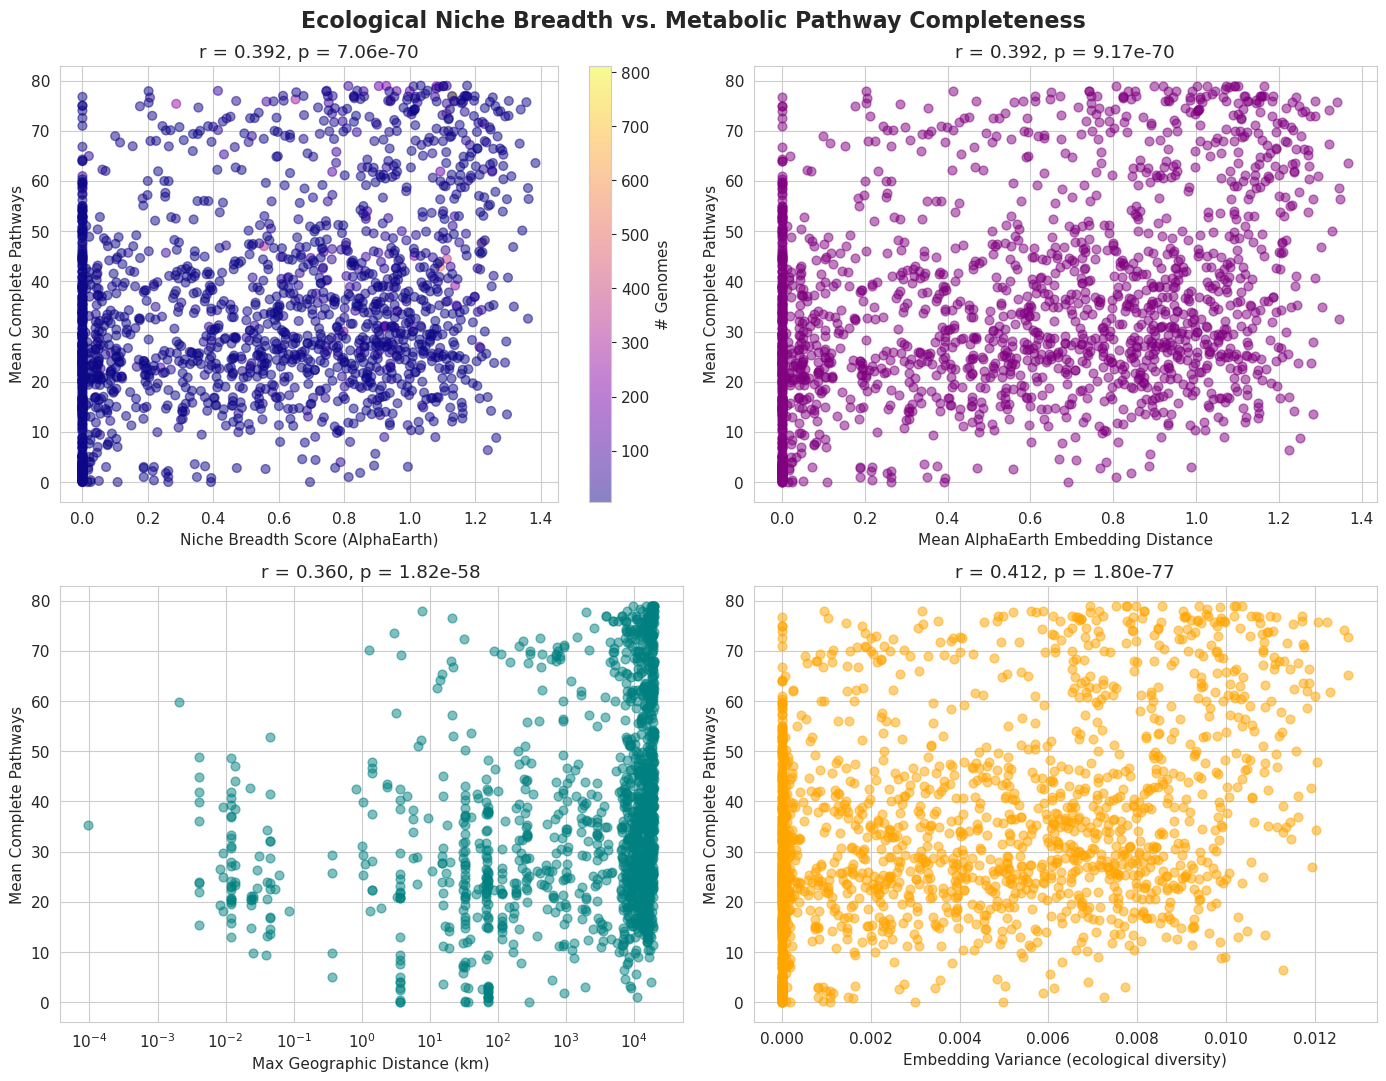

In [6]:
# Visualization: Niche Breadth vs Pathways
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle('Ecological Niche Breadth vs. Metabolic Pathway Completeness', fontsize=16, fontweight='bold')

# Plot 1: Niche breadth score vs pathways
ax = axes[0, 0]
scatter = ax.scatter(df_complete['niche_breadth_score'], df_complete['mean_complete_pathways'],
                     alpha=0.5, s=40, c=df_complete['n_genomes'], cmap='plasma')
ax.set_xlabel('Niche Breadth Score (AlphaEarth)')
ax.set_ylabel('Mean Complete Pathways')
r, p = niche_correlations['Niche Breadth Score vs Mean Complete']
ax.set_title(f"r = {r:.3f}, p = {p:.2e}")
plt.colorbar(scatter, ax=ax, label='# Genomes')

# Plot 2: Embedding distance vs pathways
ax = axes[0, 1]
ax.scatter(df_complete['mean_embedding_dist'], df_complete['mean_complete_pathways'],
           alpha=0.5, s=40, color='purple')
ax.set_xlabel('Mean AlphaEarth Embedding Distance')
ax.set_ylabel('Mean Complete Pathways')
r, p = niche_correlations['Mean Embedding Distance vs Mean Complete']
ax.set_title(f"r = {r:.3f}, p = {p:.2e}")

# Plot 3: Geographic range vs pathways (for comparison)
ax = axes[1, 0]
ax.scatter(df_complete['max_geodesic_dist_km'], df_complete['mean_complete_pathways'],
           alpha=0.5, s=40, color='teal')
ax.set_xlabel('Max Geographic Distance (km)')
ax.set_ylabel('Mean Complete Pathways')
ax.set_xscale('log')
r, p = niche_correlations['Geographic Range vs Mean Complete']
ax.set_title(f"r = {r:.3f}, p = {p:.2e}")

# Plot 4: Embedding variance vs pathways
ax = axes[1, 1]
ax.scatter(df_complete['embedding_variance'], df_complete['mean_complete_pathways'],
           alpha=0.5, s=40, color='orange')
ax.set_xlabel('Embedding Variance (ecological diversity)')
ax.set_ylabel('Mean Complete Pathways')
r, p = niche_correlations['Embedding Variance vs Mean Complete']
ax.set_title(f"r = {r:.3f}, p = {p:.2e}")

plt.tight_layout()
plt.savefig(fig_dir / 'H2_niche_breadth_vs_pathways.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Hypothesis 3: Pangenome Openness vs. Niche Breadth

Do open pangenomes correlate with broader ecological niches?

In [7]:
# Correlation analysis
print("H3: Pangenome Openness vs. Ecological Niche Breadth")
print("=" * 70)

pan_niche_correlations = {
    'Accessory/Core Ratio vs Niche Breadth': stats.pearsonr(
        df_complete['accessory_core_ratio'], 
        df_complete['niche_breadth_score']
    ),
    'Core Fraction vs Niche Breadth': stats.pearsonr(
        df_complete['core_fraction'], 
        df_complete['niche_breadth_score']
    ),
    'Accessory/Core vs Embedding Distance': stats.pearsonr(
        df_complete['accessory_core_ratio'], 
        df_complete['mean_embedding_dist']
    ),
    'Accessory/Core vs Geographic Range': stats.pearsonr(
        df_complete['accessory_core_ratio'], 
        df_complete['max_geodesic_dist_km']
    ),
}

for metric, (r, p) in pan_niche_correlations.items():
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
    print(f"{metric:50s}: r = {r:7.3f}, p = {p:.2e} {sig}")

print("\nInterpretation:")
print("  - Positive r: Open pangenomes adapt to broader niches")
print("  - Embedding distance captures ECOLOGICAL diversity, not just geography")

H3: Pangenome Openness vs. Ecological Niche Breadth
Accessory/Core Ratio vs Niche Breadth             : r =   0.324, p = 5.61e-47 ***
Core Fraction vs Niche Breadth                    : r =  -0.445, p = 1.41e-91 ***
Accessory/Core vs Embedding Distance              : r =   0.324, p = 6.31e-47 ***
Accessory/Core vs Geographic Range                : r =   0.434, p = 7.27e-87 ***

Interpretation:
  - Positive r: Open pangenomes adapt to broader niches
  - Embedding distance captures ECOLOGICAL diversity, not just geography


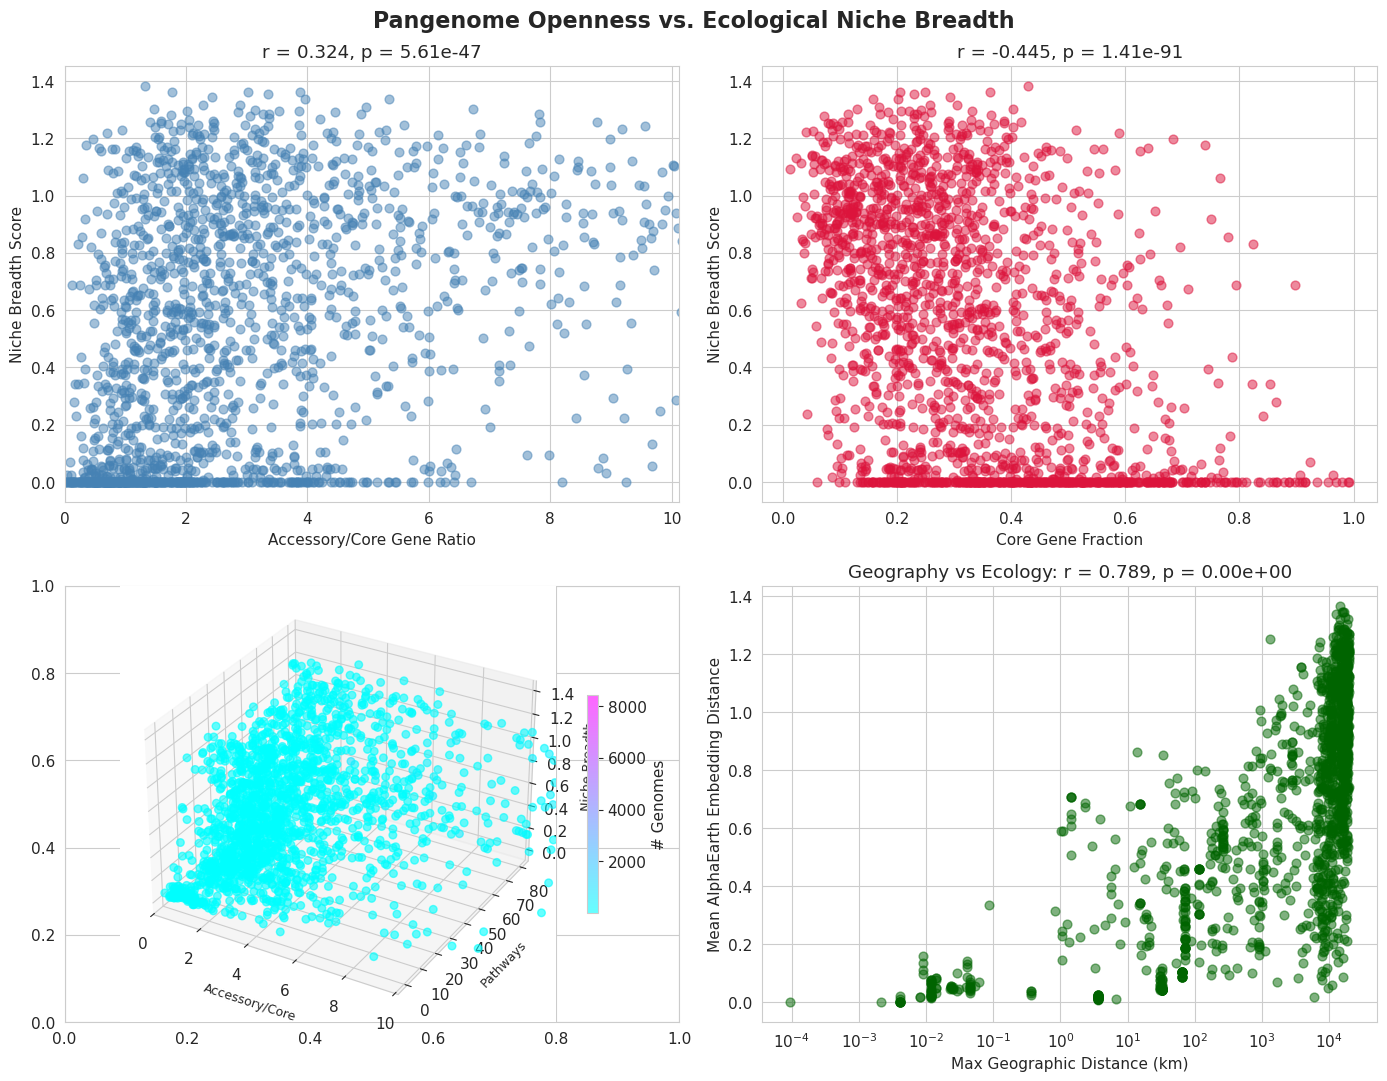

In [8]:
# Visualization: Pangenome vs Niche Breadth
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle('Pangenome Openness vs. Ecological Niche Breadth', fontsize=16, fontweight='bold')

# Plot 1: Accessory/Core vs Niche breadth
ax = axes[0, 0]
ax.scatter(df_complete['accessory_core_ratio'], df_complete['niche_breadth_score'],
           alpha=0.5, s=40, color='steelblue')
ax.set_xlabel('Accessory/Core Gene Ratio')
ax.set_ylabel('Niche Breadth Score')
r, p = pan_niche_correlations['Accessory/Core Ratio vs Niche Breadth']
ax.set_title(f"r = {r:.3f}, p = {p:.2e}")
ax.set_xlim(0, df_complete['accessory_core_ratio'].quantile(0.95))

# Plot 2: Core fraction vs Niche breadth
ax = axes[0, 1]
ax.scatter(df_complete['core_fraction'], df_complete['niche_breadth_score'],
           alpha=0.5, s=40, color='crimson')
ax.set_xlabel('Core Gene Fraction')
ax.set_ylabel('Niche Breadth Score')
r, p = pan_niche_correlations['Core Fraction vs Niche Breadth']
ax.set_title(f"r = {r:.3f}, p = {p:.2e}")

# Plot 3: 3D relationship
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(223, projection='3d')
scatter = ax.scatter(df_complete['accessory_core_ratio'], 
                     df_complete['mean_complete_pathways'],
                     df_complete['niche_breadth_score'],
                     c=df_complete['no_genomes'], cmap='cool',
                     alpha=0.6, s=30)
ax.set_xlabel('Accessory/Core', fontsize=9)
ax.set_ylabel('Pathways', fontsize=9)
ax.set_zlabel('Niche Breadth', fontsize=9)
ax.set_xlim(0, df_complete['accessory_core_ratio'].quantile(0.95))
plt.colorbar(scatter, ax=ax, label='# Genomes', shrink=0.5)

# Plot 4: Embedding distance vs geographic distance
ax = axes[1, 1]
ax.scatter(df_complete['max_geodesic_dist_km'], df_complete['mean_embedding_dist'],
           alpha=0.5, s=40, color='darkgreen')
ax.set_xlabel('Max Geographic Distance (km)')
ax.set_ylabel('Mean AlphaEarth Embedding Distance')
ax.set_xscale('log')
r, p = stats.pearsonr(df_complete['max_geodesic_dist_km'], df_complete['mean_embedding_dist'])
ax.set_title(f"Geography vs Ecology: r = {r:.3f}, p = {p:.2e}")

plt.tight_layout()
plt.savefig(fig_dir / 'H3_pangenome_vs_niche_breadth.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Summary and Interpretation

In [9]:
print("=" * 70)
print("ANALYSIS SUMMARY")
print("=" * 70)

print(f"\nDataset: {len(df_complete)} species with complete data\n")

def interpret_correlation(r, p, hypothesis):
    """Interpret correlation strength and significance."""
    strength = "Strong" if abs(r) > 0.5 else "Moderate" if abs(r) > 0.3 else "Weak"
    direction = "positive" if r > 0 else "negative"
    sig = "SIGNIFICANT" if p < 0.001 else "Significant" if p < 0.05 else "Not significant"
    
    print(f"{hypothesis}")
    print(f"  {strength} {direction} correlation (r = {r:.3f}, p = {p:.2e})")
    print(f"  Status: {sig}")
    print()

# H1: Pangenome → Pathways
r, p = correlations['Accessory/Core Ratio vs Mean Complete']
interpret_correlation(r, p, "H1: Pangenome Openness → Pathway Completeness")

# H2: Niche → Pathways
r, p = niche_correlations['Niche Breadth Score vs Mean Complete']
interpret_correlation(r, p, "H2: Niche Breadth → Pathway Completeness")

# H3: Pangenome → Niche
r, p = pan_niche_correlations['Accessory/Core Ratio vs Niche Breadth']
interpret_correlation(r, p, "H3: Pangenome Openness → Niche Breadth")

print("=" * 70)
print("\nFigures saved:")
print("  - H1_pangenome_vs_pathways.png")
print("  - H2_niche_breadth_vs_pathways.png")
print("  - H3_pangenome_vs_niche_breadth.png")
print("\nAll figures saved to ../figures/")

ANALYSIS SUMMARY

Dataset: 1872 species with complete data

H1: Pangenome Openness → Pathway Completeness
  Weak positive correlation (r = 0.107, p = 3.62e-06)
  Status: SIGNIFICANT

H2: Niche Breadth → Pathway Completeness
  Moderate positive correlation (r = 0.392, p = 7.06e-70)
  Status: SIGNIFICANT

H3: Pangenome Openness → Niche Breadth
  Moderate positive correlation (r = 0.324, p = 5.61e-47)
  Status: SIGNIFICANT


Figures saved:
  - H1_pangenome_vs_pathways.png
  - H2_niche_breadth_vs_pathways.png
  - H3_pangenome_vs_niche_breadth.png

All figures saved to ../figures/
